In [1]:
import pandas as pd
import rpy2
import warnings
import numpy as np
warnings.filterwarnings("ignore")

In [2]:
%load_ext rpy2.ipython

In [7]:
#%%R -o election
#election <- read.csv("2008ElectionResult.csv")

In [2]:
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

In [3]:
df = pd.read_stata('pew_research_center_june_elect_wknd_data.dta')

In [4]:
df.age.max()

'dk/refused'

In [6]:
election = pd.read_csv("2008ElectionResult.csv")
states_out = ['alaska', 'hawaii']
election.columns

Index(['state', 'vote_Obama', 'vote_Obama_pct', 'vote_McCain',
       'vote_McCain_pct', 'electoral_vote_dem', 'electoral_vote_rep'],
      dtype='object')

In [7]:
lib = (df[df['ideo'].notnull()]
                    .loc[:, ['state', 'ideo']]
                    .loc[df['ideo'] == 'very liberal']
                    .groupby('state')
                    .count()
                    .query('state not in @states_out').reset_index(drop = True)
      )

In [9]:
n = (df[df['ideo'].notnull()]
                    .loc[:, ['state', 'ideo']]
                    #.loc[df['ideo'] == 'very liberal']
                    .groupby('state')
                    .count()
                    .query('state not in @states_out').reset_index(drop = True)
    )

In [10]:
election = election.assign(abb = election['state'].replace(us_state_to_abbrev), 
                           state = election['state'].str.lower().replace({'district of columbia':'washington dc'}),
                           obama_won = np.where(election['vote_Obama_pct'] > 50, 'yes', 'no')) \
                   .query('state not in @states_out').reset_index(drop = True) \
                   .assign(lib = lib, n = n, lib_prop = (lib / n) * 100)

In [11]:
election.head()

,state,vote_Obama,vote_Obama_pct,vote_McCain,vote_McCain_pct,electoral_vote_dem,electoral_vote_rep,abb,obama_won,lib,n,lib_prop
0,alabama,811764,38.8,1264879,60.4,NaN,9.0,AL,no,30,617,4.862237
1,arizona,948648,45.0,1132560,53.8,NaN,10.0,AZ,no,28,533,5.253283
2,arkansas,418049,38.8,632672,58.8,NaN,6.0,AR,no,7,304,2.302632
3,california,7245731,60.9,4434146,37.3,55.0,NaN,CA,yes,179,2809,6.372375
4,colorado,1216793,53.5,1020135,44.9,9.0,NaN,CO,yes,27,465,5.806452


In [12]:
election.columns

Index(['state', 'vote_Obama', 'vote_Obama_pct', 'vote_McCain',
       'vote_McCain_pct', 'electoral_vote_dem', 'electoral_vote_rep', 'abb',
       'obama_won', 'lib', 'n', 'lib_prop'],
      dtype='object')

In [13]:
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row 
from bokeh.plotting import figure

output_notebook()

Loading BokehJS ...

In [14]:
from bokeh.transform import factor_cmap
from bokeh.models import ColumnDataSource, Label, LabelSet, Range1d, BoxAnnotation

In [15]:
index_cmap = factor_cmap('obama_won', palette=['red', 'blue'], factors=sorted(election.obama_won.unique()))
elec=ColumnDataSource(data=election)

In [16]:
p = figure(title = "Proportion of liberals vs Obama votes", y_range=Range1d(0, 15), x_range=Range1d(0, 100))
p.scatter('vote_Obama_pct','lib_prop',source=elec,line_color = 'white', fill_alpha=4, fill_color=index_cmap,size=4)
labels = LabelSet(y='lib_prop',x='vote_Obama_pct', text='abb', level='glyph',text_font_size='6pt',text_color=index_cmap,
              x_offset=-6, y_offset=0, source=elec, render_mode='canvas')
p.yaxis.axis_label = 'Proportions of liberals in the survey'
p.xaxis.axis_label = 'Proportion of Obama votes'
low_box = BoxAnnotation(right=50, fill_alpha=0.1, fill_color='red')
high_box = BoxAnnotation(left=50, fill_alpha=0.1, fill_color='blue')
p.add_layout(low_box)
p.add_layout(high_box)
p.add_layout(labels)
show(p)

#### (b) Graph the Bayes posterior mean in each state vs. Obama vote share.

In [17]:
import matplotlib.pyplot as plt
import scipy.stats as st

In [18]:
election[['lib', 'n']].head()

,lib,n
0,30,617
1,28,533
2,7,304
3,179,2809
4,27,465


In [19]:
rate = np.mean(election['lib'] / election['n']) / np.var(election['lib'] / election['n'], ddof = 1)
shape = rate * np.mean(election['lib'] / election['n'])

In [20]:
x = np.linspace(0, 0.3, 100)
y = st.gamma.pdf(x, shape, scale = 1/rate)

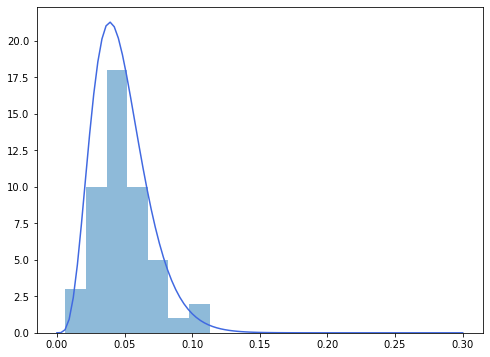

In [21]:
plt.figure(figsize = (8, 6))
plt.hist(election['lib']/election['n'], bins = 7, alpha = 0.5)
plt.plot(x, y, c = 'royalblue');

In [22]:
election = election.assign(posterior_mean = ((shape + election['lib']) / (rate + election['n']))*100)

In [23]:
election.head()

,state,vote_Obama,vote_Obama_pct,vote_McCain,vote_McCain_pct,electoral_vote_dem,electoral_vote_rep,abb,obama_won,lib,n,lib_prop,posterior_mean
0,alabama,811764,38.8,1264879,60.4,NaN,9.0,AL,no,30,617,4.862237,4.849380
1,arizona,948648,45.0,1132560,53.8,NaN,10.0,AZ,no,28,533,5.253283,5.169113
2,arkansas,418049,38.8,632672,58.8,NaN,6.0,AR,no,7,304,2.302632,2.984922
3,california,7245731,60.9,4434146,37.3,55.0,NaN,CA,yes,179,2809,6.372375,6.309512
4,colorado,1216793,53.5,1020135,44.9,9.0,NaN,CO,yes,27,465,5.806452,5.602358


In [24]:
elec=ColumnDataSource(data=election)

In [25]:
p = figure(title = "Proportion of liberals vs Obama votes", y_range=Range1d(0, 15), x_range=Range1d(0, 100))
p.scatter('vote_Obama_pct','posterior_mean',source=elec,line_color = 'white', fill_alpha=4, fill_color=index_cmap,size=4)
labels = LabelSet(y='posterior_mean',x='vote_Obama_pct', text='abb', level='glyph',text_font_size='6pt',text_color=index_cmap,
              x_offset=-6, y_offset=0, source=elec, render_mode='canvas')
p.yaxis.axis_label = 'Bayesian Mean of Proportion in Survey'
p.xaxis.axis_label = 'Proportion of Obama votes'
low_box = BoxAnnotation(right=50, fill_alpha=0.1, fill_color='red')
high_box = BoxAnnotation(left=50, fill_alpha=0.1, fill_color='blue')
p.add_layout(low_box)
p.add_layout(high_box)
p.add_layout(labels)
show(p)